In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

In [2]:
import tensorflow as tf

In [3]:
from sklearn.metrics import log_loss
from keras.losses import BinaryCrossentropy as LogLoss
from keras.metrics import BinaryCrossentropy

In [4]:
from keras.layers import Dense, Activation, Input, Concatenate, Dropout

In [5]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

ImportError: cannot import name 'CategoryEncoding' from 'tensorflow.keras.layers.experimental.preprocessing' (/home/paulus/miniconda3/lib/python3.8/site-packages/tensorflow/keras/layers/experimental/preprocessing/__init__.py)

In [2]:
import autokeras as ak

In [3]:
import keras
from keras.models import Model
import kerastuner

## Keras notebook, improvement over moa-basic-keras
1. Manually transform data: categorical, simple MinMaxScaler, categorical, PowerTransformer.
1. Run another basic autokeras on this more amenable dataset.
1. Tune the resulting keras-from-autokeras model.
1. Architect a similar model to one of the top performing notebooks on Kaggle.
1. Tune this model architecture.
1. Compare results and consider possibilities for improvements:
    1. Transformers
    1. RNNs
    1. Do more research
1. Additional possibilities from Kaggle notebooks and elsewhere:
    1. More sophisticated dimensionality reduction with t-SNE
    

In [4]:
tf_df = pd.read_csv('../train_features.csv',index_col='sig_id')
tts_df = pd.read_csv('../train_targets_scored.csv',index_col='sig_id')
tf_df['cp_type']=tf_df['cp_type'].astype('category')
scaler = MinMaxScaler(feature_range=(-0.5,0.5))
tf_df['cp_time']=scaler.fit_transform((np.array(tf_df['cp_time'])).reshape(-1,1))
tf_df['cp_dose']=tf_df['cp_dose'].astype('category')
transformer = PowerTransformer()
tf_df.loc[:,'g-0':'c-99']=transformer.fit_transform(tf_df.loc[:,'g-0':'c-99'])

In [7]:
print(tf_df.shape, tts_df.shape)

(23814, 875) (23814, 206)


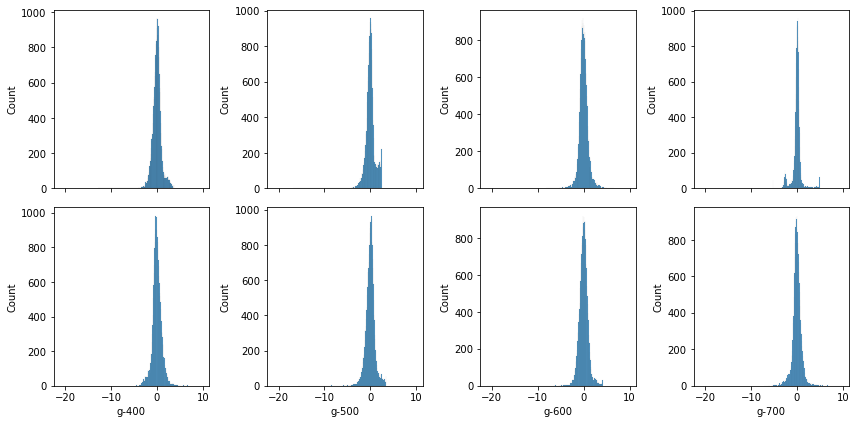

In [6]:
f, axs = plt.subplots(2,4,figsize=(12,6),sharex=True)
for i in range(0,701,100):
    sns.histplot(data=tf_df,x='g-'+str(i),ax=axs[i//400,i%400//100])
f.tight_layout()

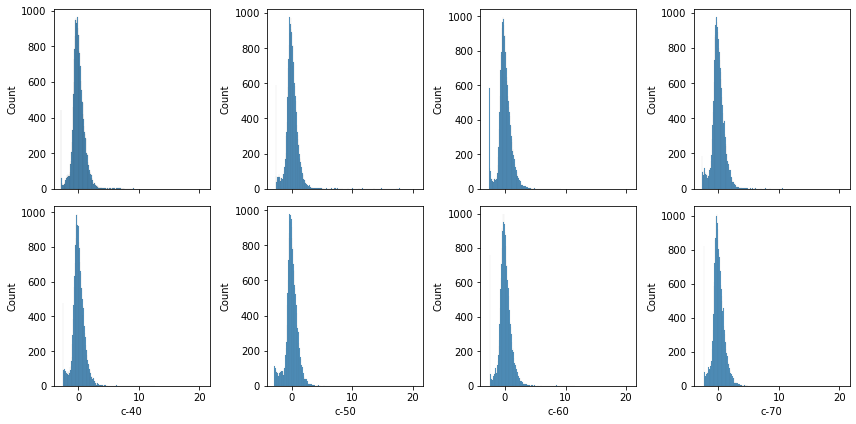

In [7]:
f, axs = plt.subplots(2,4,figsize=(12,6),sharex=True)
for i in range(0,71,10):
    sns.histplot(data=tf_df,x='c-'+str(i),ax=axs[i//40,i%40//10])
f.tight_layout()

Not as elegant as I hoped, but to my knowledge this should train significantly better.

In [8]:
ak_pass2 = ak.StructuredDataClassifier(overwrite=True,max_trials=5,loss='binary_crossentropy',
                                       metrics=['binary_crossentropy','accuracy'])
ak_pass2.fit(tf_df,tts_df,epochs=10)

Trial 5 Complete [00h 06m 27s]
val_accuracy: 0.08962462842464447

Best val_accuracy So Far: 0.10080134868621826
Total elapsed time: 00h 28m 32s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
745/745 [==============================] - 25s 34ms/step - loss: 3.5734 - binary_crossentropy: 0.0220 - accuracy: 0.0403
Epoch 2/10
745/745 [==============================] - 27s 36ms/step - loss: 3.9371 - binary_crossentropy: 0.0221 - accuracy: 0.0580
Epoch 3/10
745/745 [==============================] - 27s 36ms/step - loss: 5.0767 - binary_crossentropy: 0.0241 - accuracy: 0.0446
Epoch 4/10
745/745 [==============================] - 26s 34ms/step - loss: 6.5732 - binary_crossentropy: 0.0254 - accuracy: 0.0372
Epoch 5/10
745/745 [==============================] - 45s 60ms/step - loss: 6.9710 - binary_crossentropy: 0.0260 - accuracy: 0.0357
Epoch 6/10
745/745 [==============================] - 43s 57ms/step - loss: 8.1273 - binary_crossentropy: 0.0259 - accuracy: 0.0352
Epoch 7/10
745/745 [======

In [10]:
preds = ak_pass2.predict(tf_df)
log_loss(tts_df,preds)

21.665417056654878

In [11]:
ak_pass2.evaluate(tf_df,tts_df)

745/745 [==============================] - 17s 23ms/step - loss: 5.0789 - binary_crossentropy: 0.0203 - accuracy: 0.0417


[5.078915119171143, 0.020280111581087112, 0.04174015298485756]

In [12]:
preds = ak_pass2.predict(tf_df)
log_loss(tts_df,preds)

21.665417056654878

In [13]:
keras2 = ak_pass2.export_model()

In [14]:
keras2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 875)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 875)               0         
_________________________________________________________________
normalization (Normalization (None, 875)               1751      
_________________________________________________________________
dense (Dense)                (None, 64)                56064     
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
re_lu (ReLU)                 (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)               

Compare this to the previous autokeras model. This one's log loss is even a little worse than that one; neither is at all credible.

In [5]:
types_dict = {'cp_type':'categorical','cp_time':'numerical','cp_dose':'categorical'}
for name in tf_df.columns[3:]:
    types_dict[name]='numerical'
types_dict

{'cp_type': 'categorical',
 'cp_time': 'numerical',
 'cp_dose': 'categorical',
 'g-0': 'numerical',
 'g-1': 'numerical',
 'g-2': 'numerical',
 'g-3': 'numerical',
 'g-4': 'numerical',
 'g-5': 'numerical',
 'g-6': 'numerical',
 'g-7': 'numerical',
 'g-8': 'numerical',
 'g-9': 'numerical',
 'g-10': 'numerical',
 'g-11': 'numerical',
 'g-12': 'numerical',
 'g-13': 'numerical',
 'g-14': 'numerical',
 'g-15': 'numerical',
 'g-16': 'numerical',
 'g-17': 'numerical',
 'g-18': 'numerical',
 'g-19': 'numerical',
 'g-20': 'numerical',
 'g-21': 'numerical',
 'g-22': 'numerical',
 'g-23': 'numerical',
 'g-24': 'numerical',
 'g-25': 'numerical',
 'g-26': 'numerical',
 'g-27': 'numerical',
 'g-28': 'numerical',
 'g-29': 'numerical',
 'g-30': 'numerical',
 'g-31': 'numerical',
 'g-32': 'numerical',
 'g-33': 'numerical',
 'g-34': 'numerical',
 'g-35': 'numerical',
 'g-36': 'numerical',
 'g-37': 'numerical',
 'g-38': 'numerical',
 'g-39': 'numerical',
 'g-40': 'numerical',
 'g-41': 'numerical',
 'g-42'

In [6]:
cols = list(tf_df.columns)

In [22]:
ak_pass3 = ak.AutoModel(
        inputs=[ak.StructuredDataInput(column_names=cols,column_types=types_dict)],
        outputs=[ak.ClassificationHead(multi_label=True,loss=LogLoss(),metrics=[BinaryCrossentropy()])]
    )
ak_pass3.fit(tf_df,tts_df,epochs=5)

Trial 61 Complete [00h 02m 43s]
val_loss: 0.01714763231575489

Best val_loss So Far: 0.01657630130648613
Total elapsed time: 02h 52m 12s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
745/745 [==============================] - 20s 27ms/step - loss: 0.0508 - binary_crossentropy: 0.0453
Epoch 2/5
745/745 [==============================] - 21s 28ms/step - loss: 0.0190 - binary_crossentropy: 0.0190
Epoch 3/5
745/745 [==============================] - 22s 29ms/step - loss: 0.0171 - binary_crossentropy: 0.0171
Epoch 4/5
745/745 [==============================] - 21s 28ms/step - loss: 0.0162 - binary_crossentropy: 0.0162
Epoch 5/5
745/745 [==============================] - 21s 28ms/step - loss: 0.0155 - binary_crossentropy: 0.0155
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [23]:
ak_pass3.evaluate(tf_df,tts_df)

745/745 [==============================] - 14s 19ms/step - loss: 0.0138 - binary_crossentropy: 0.0138


[0.013757994398474693, 0.013757994398474693]

In [24]:
preds3 = ak_pass3.predict(tf_df)
print("AutoKeras model 3 log loss:",log_loss(tts_df,preds3))
keras3 = ak_pass3.export_model()
keras3.summary()

AutoKeras model 3 log loss: 17.292593892522195
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 875)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 875)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                56064     
_________________________________________________________________
re_lu (ReLU)                 (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 206)               13390     
_________________________________________________________________
classif

In [27]:
with open('autokeras-v3.pkl','wb') as cellar:
    pickle.dump([keras3],cellar)

TypeError: cannot pickle '_thread.RLock' object

In [28]:
with open('autokeras-v3.pkl','wb') as cellar:
    pickle.dump([ak_pass3],cellar)

TypeError: cannot pickle 'tensorflow.python._pywrap_tf_session.TF_Output' object

Manual preprocessing steps taken from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

In [17]:
play_df = tf_df.copy()

In [18]:
stuff = play_df.pop('cp_type')

In [19]:
print(type(stuff),play_df.head())

<class 'pandas.core.series.Series'>               cp_time cp_dose       g-0       g-1       g-2       g-3  \
sig_id                                                                  
id_000644bb2     -0.5      D1  0.840092  0.799637 -0.360212 -0.762460   
id_000779bfc      0.5      D1  0.095368  0.609459  0.173882  0.084506   
id_000a6266a      0.0      D1  0.551203  0.830403  1.326615 -0.072048   
id_0015fd391      0.0      D1 -0.572952 -0.209667 -0.377930  0.573085   
id_001626bd3      0.5      D2 -0.335672 -0.393710  0.799549  0.730024   

                   g-4       g-5       g-6       g-7  ...      c-90      c-91  \
sig_id                                                ...                       
id_000644bb2 -0.179328 -0.800311 -1.221088 -0.027312  ...  0.295563  0.242258   
id_000779bfc  0.954197  0.521283  0.252322  0.422723  ... -0.423036  1.001666   
id_000a6266a -0.012249  1.299872  0.182260  0.264994  ... -0.623206 -0.560964   
id_0015fd391  3.239971 -0.648433 -2.386051  0.2

In [20]:
def dataframe_to_dataset(dataframe,targets):
    dataframe = dataframe.copy()
    labels = targets.copy()
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), dict(labels)))
    # ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [15]:
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    print('second checkpoint')
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
    print('third checkpoint')
    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)
    print('fourth checkpoint')
    # Turn the string input into integer indices
    encoded_feature = index(feature)
    print('fifth checkpoint')
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")
    print('sixth checkpoint')
    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)
    print('sevent checkpoint')
    # Learn the space of possible indices
    encoder.adapt(feature_ds)
    print('eighth checkpoint')
    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    print('ninth checkpoint')
    return encoded_feature

In [29]:
def encode_dataframes(input_df,output_df):
    dataset = dataframe_to_dataset(input_df,output_df)
    print('first checkpoint')
    dataset.batch(32)
    all_inputs = []
    all_features = []
    for i, label in enumerate(input_df.columns):
        print('loop number',i)
        if label in ['cp_type','cp_dose']:
            print('a string column')
            input_item = keras.Input(shape=(1,),name=label,dtype='string')
            all_inputs.append(input_item)
            all_features.append(encode_string_categorical_feature(input_item,label,dataset))
        else:
            print('a numeric column')
            input_item = keras.Input(shape=(1,),name=label)
            all_inputs.append(input_item)
            all_features.append(encode_numerical_feature(input_item,label,dataset))
    return dataset, all_inputs, layers.concatenate(all_features)

In [30]:
ds, inputs1, input1_layer = encode_dataframes(tf_df,tts_df)
print('did we get here?')
layer11 = Dense(64,activation='relu')(input1_layer)
layer1d = Dropout(0.2)(layer11)
layer12 = Dense(206,activation='sigmoid')(layer1d)

model1 = Model(inputs=inputs1, outputs=layer12)
model1.summary()

first checkpoint
loop number 0
a string column


KeyboardInterrupt: 

In [ ]:
model1.compile("adam", "binary_crossentropy", metrics=["binary_crossentropy","accuracy","AUC"])

In [ ]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model1, show_shapes=True, rankdir="LR")

In [ ]:
n_epochs = 40
print('Starting Training')
model1.fit(ds,epochs=n_epochs)
print('Finished Training')